在了解了线性回归的背景知识之后，我们可以动手实现该算法了。尽管强大的深度学习框架可以减少大量重复性工作，但是过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此本节将介绍如何只利用Tensor和autograd来实现一个线性回归的训练。

首先，导入本节内容需要的包或者模块，其中matplotlib包可以用于作图，且设置成嵌入显示。

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

##### 生成数据集

我们构建一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和模型参数的区别。
加入我们的训练数据集样本为1000，输入个数为（特征数）为2。我们碎金生成批量的样本特征$$X∈{R}^{1000*2},$$我们使用线性回归模型的真实权重$$W=[2,-3.4]^{T}$$和偏差b=4.2，以及一个随机噪音项ϵ 来生成标签
$$ y=Xw+b+ϵ,$$其中噪声项 ϵ服从均值为0，标准差为0.01的正太分布。噪音代表了数据汇总无意义的干扰。

In [2]:
num_inputs =2   ## 特征数量
num_examples=1000   # 样本量
true_w=[2,-3.4]  # 真实的权重系数
true_b=4.2  # 真实的偏置量
features = torch.randn(num_examples,num_inputs,dtype=torch.float32)   # 生成随机的特征
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b  # 生成随机的标签
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)  #在标签上加上随机噪声项
print(features[0],labels[0])  # 查看第一个样本



tensor([-0.4866,  0.9289]) tensor(0.0616)


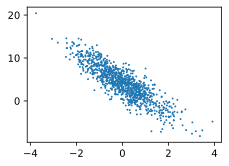

In [3]:
def use_svg_display():
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
    
    
    
## 可以单独写一个代码重复利用，比如d2lzh_pytorch 中加上这两个函数
# import sys
# sys.path.append('..')
# from d2lzh_pytorch import *

set_figsize()
plt.scatter(features[:,1].numpy(),labels.numpy(),1)

##### 读取数据

In [4]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])  # 最后一次可能不足一个batch
        yield features.index_select(0,j),labels.index_select(0,j)

In [5]:
batch_size=10
for X ,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[ 0.0097,  0.3166],
        [-0.9294, -0.5351],
        [ 0.5398,  0.4626],
        [ 0.5905,  0.9588],
        [ 0.1730, -0.3228],
        [ 1.3608, -0.8205],
        [ 1.5391, -0.6738],
        [-1.4577,  0.6428],
        [-1.4004,  0.3694],
        [-0.6668, -0.4032]]) tensor([ 3.1422,  4.1823,  3.7059,  2.1282,  5.6544,  9.7055,  9.5682, -0.9014,
         0.1326,  4.2385])


##### 初始化模型参数

In [6]:
# 初始化w为一个2行1列的tensor,b初始化为0
w= torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)


In [7]:
# 之后的训练模型中，需要对这些参数来迭代参数的值，因此我们要让求导的参数设置为True
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

##### 定义模型

In [8]:
def linreg(X,w,b):
    return torch.mm(X,w)+b

#####  定义损失函数

In [9]:
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2

##### 定义优化算法

In [10]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -=lr* param.grad/batch_size   
# 注意这里更改param时用的是param.data

##### 训练模型

在训练中，我们将多次迭代模型的参数，在每次迭代中，我们根据当前读取的小批量数据样本(特征X，标签y),通过调用反向传播函数backward计算小批量的随机梯度，并调用优化算法sgd迭代模型参数。
我们之前设置的batch_size为10，每个小批量的损失$l$的形状为（10，1）。由于变量$l$并不是一个标量，我们调用.sum()将其求和得到一个标量，再运行$l$.backward(),得到该变量的有关模型参数的梯度。**注意每次更新完参数后需要将参数的梯度清零**

In [11]:
lr = 0.03
num_epochs=3
net = linreg
loss= squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l =loss(net(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        
        w.grad.data.zero_()
        b.grad.data.zero_()
    trian_l= loss(net(features,w,b),labels)
    print('epoch %d loss %f'  %(epoch+1,trian_l.mean().item()))

epoch 1 loss 0.038065
epoch 2 loss 0.000144
epoch 3 loss 0.000050


In [12]:
print(true_w,'\n',w)
print(true_b,'\n',b)

[2, -3.4] 
 tensor([[ 1.9996],
        [-3.4005]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)
